# Std target

# Imports

In [1]:
%matplotlib inline

import src.utils as udf

import gc
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Lasso

import lightgbm as lgb
import xgboost as xgb

# Data

In [2]:
path = '../data/'

In [3]:
train = pd.read_pickle(f'{path}from_mod/train.pkl')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 18 columns):
building_id           uint16
meter                 uint8
meter_reading         float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(7), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 1.1+ GB


In [4]:
train = udf.reduce_mem_usage(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 18 columns):
building_id           uint16
meter                 uint8
meter_reading         float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(7), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 1.1+ GB


In [5]:
test = pd.read_pickle(f'{path}from_sub/test.pkl')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 17 columns):
building_id           uint16
meter                 uint8
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             int64
hour                  int64
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            int64
country               object
is_holiday            int64
dtypes: float32(6), int64(4), object(2), uint16(2), uint32(1), uint8(2)
memory usage: 3.5+ GB


In [6]:
test = udf.reduce_mem_usage(test)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 17 columns):
building_id           uint16
meter                 uint8
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(6), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 2.4+ GB


In [7]:
submission = pd.read_csv(f'{path}raw/test/sample_submission.csv')
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
row_id           int64
meter_reading    int64
dtypes: int64(2)
memory usage: 636.3 MB


In [8]:
submission = udf.reduce_mem_usage(submission)
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
row_id           uint32
meter_reading    uint8
dtypes: uint32(1), uint8(1)
memory usage: 198.8 MB


In [9]:
mb = pd.read_pickle(f'{path}from_sub/mb.pkl')
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 9 columns):
row_id          uint32
building_id     uint16
meter           uint8
timestamp       datetime64[ns]
site_id         uint8
primary_use     object
square_feet     uint32
year_built      uint16
missing_year    uint8
dtypes: datetime64[ns](1), object(1), uint16(2), uint32(2), uint8(3)
memory usage: 1.5+ GB


In [10]:
mb = udf.reduce_mem_usage(mb)
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 9 columns):
row_id          uint32
building_id     uint16
meter           uint8
timestamp       datetime64[ns]
site_id         uint8
primary_use     object
square_feet     uint32
year_built      uint16
missing_year    uint8
dtypes: datetime64[ns](1), object(1), uint16(2), uint32(2), uint8(3)
memory usage: 1.5+ GB


In [11]:
del path
gc.collect()

88

# Target

In [12]:
train.describe()

,building_id,meter,meter_reading,dew_temperature,sea_level_pressure,wind_speed,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,is_holiday
count,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07,1.826490e+07
mean,8.037511e+02,5.951358e-01,3.413591e+02,7.850799e+00,1.016059e+03,3.380148e+00,1.062238e+05,1.967027e+03,5.999500e-01,1.877835e+02,1.152170e+01,-5.101073e-02,-4.493904e-02,6.401447e+01,2.852353e-01,3.077461e-02
std,4.205652e+02,8.913411e-01,8.350884e+02,1.013072e+01,7.257745e+00,2.272173e+00,1.147711e+05,1.992809e+01,4.899082e-01,1.047606e+02,6.911360e+00,6.678199e-01,6.535204e-01,2.288399e+01,4.515265e-01,1.727065e-01
min,0.000000e+00,0.000000e+00,1.000000e-04,-3.500000e+01,9.682000e+02,0.000000e+00,2.830000e+02,1.900000e+03,0.000000e+00,1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,3.751658e+00,0.000000e+00,0.000000e+00
25%,4.130000e+02,0.000000e+00,2.853000e+01,6.000000e-01,1.011600e+03,2.100000e+00,3.130000e+04,1.961000e+03,0.000000e+00,1.000000e+02,6.000000e+00,-7.660444e-01,-6.427876e-01,4.760014e+01,0.000000e+00,0.000000e+00
50%,8.930000e+02,0.000000e+00,9.136780e+01,8.900000e+00,1.016100e+03,3.100000e+00,7.180600e+04,1.964000e+03,1.000000e+00,1.900000e+02,1.200000e+01,0.000000e+00,0.000000e+00,6.723316e+01,0.000000e+00,0.000000e+00
75%,1.180000e+03,1.000000e+00,2.793400e+02,1.610000e+01,1.020507e+03,4.600000e+00,1.389770e+05,1.971000e+03,1.000000e+00,2.780000e+02,1.800000e+01,5.000000e-01,5.000000e-01,8.362017e+01,1.000000e+00,0.000000e+00
max,1.448000e+03,3.000000e+00,1.165430e+04,2.610000e+01,1.045500e+03,1.900000e+01,8.750000e+05,2.017000e+03,1.000000e+00,3.660000e+02,2.300000e+01,1.000000e+00,1.000000e+00,1.192694e+02,1.000000e+00,1.000000e+00


In [13]:
train['meter_reading'] /= train.square_feet
train['meter_reading'] *= train.square_feet.mean()
train.meter_reading.describe()

count    1.826490e+07
mean     3.741392e+02
std      9.762786e+02
min      1.757431e-04
25%      7.217422e+01
50%      1.519035e+02
75%      3.275629e+02
max      2.060227e+05
Name: meter_reading, dtype: float64

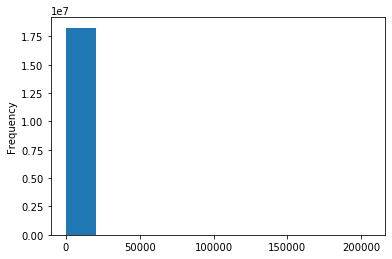

In [14]:
train.meter_reading.plot(kind='hist')

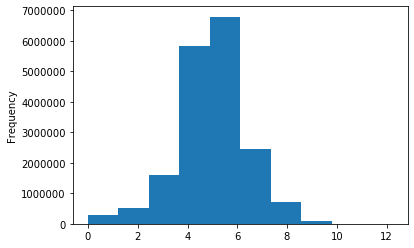

In [15]:
np.log1p(train.meter_reading).plot(kind='hist')

# Features

In [16]:
train.head()

,building_id,meter,meter_reading,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,46,0,183.258734,19.4,1019.400024,0.0,Retail,9045,2016,0,1,0,0.0,0.000000,100.000000,0,US,1
1,74,0,3.453766,19.4,1019.400024,0.0,Parking,387638,1997,0,1,0,0.0,0.000000,100.000000,0,US,1
2,93,0,48.908398,19.4,1019.400024,0.0,Office,33370,1982,0,1,0,0.0,0.000000,100.000000,0,US,1
3,105,0,48.898662,2.4,1020.900024,3.1,Education,50623,1960,1,1,0,-0.5,-0.866025,90.549408,0,UK,1
4,106,0,7.404435,2.4,1020.900024,3.1,Education,5374,1960,1,1,0,-0.5,-0.866025,90.549408,0,UK,1


In [17]:
test.head()

,building_id,meter,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0,0,12.8,1022.099976,2.1,Education,7432,2008,0,1,0,-0.642788,0.766044,83.409012,1,US,1
1,1,0,12.8,1022.099976,2.1,Education,2720,2004,0,1,0,-0.642788,0.766044,83.409012,1,US,1
2,2,0,12.8,1022.099976,2.1,Education,5376,1991,0,1,0,-0.642788,0.766044,83.409012,1,US,1
3,3,0,12.8,1022.099976,2.1,Education,23685,2002,0,1,0,-0.642788,0.766044,83.409012,1,US,1
4,4,0,12.8,1022.099976,2.1,Education,116607,1975,0,1,0,-0.642788,0.766044,83.409012,1,US,1


In [18]:
train.drop(['missing_year', 'wind_direction_x'], axis=1, inplace=True)
feats = train.drop('meter_reading', axis=1).columns
test = test[feats]
test.head()

,building_id,meter,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,dayofyear,hour,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0,0,12.8,1022.099976,2.1,Education,7432,2008,1,0,0.766044,83.409012,1,US,1
1,1,0,12.8,1022.099976,2.1,Education,2720,2004,1,0,0.766044,83.409012,1,US,1
2,2,0,12.8,1022.099976,2.1,Education,5376,1991,1,0,0.766044,83.409012,1,US,1
3,3,0,12.8,1022.099976,2.1,Education,23685,2002,1,0,0.766044,83.409012,1,US,1
4,4,0,12.8,1022.099976,2.1,Education,116607,1975,1,0,0.766044,83.409012,1,US,1


In [19]:
del feats
gc.collect()

99

# Split data

In [20]:
train_df = []
test_df = []

for m in range(4):
    df_train = train[train.meter == m].drop('meter', axis=1)
    df_test = test[test.meter == m].drop('meter', axis=1)
    train_df.append(df_train)
    test_df.append(df_test)
    print(f'Meter {m}:', df_train.shape, df_test.shape)

Meter 0: (11530268, 15) (24755760, 14)
Meter 1: (3518870, 15) (8724960, 14)
Meter 2: (2296049, 15) (5676480, 14)
Meter 3: (919708, 15) (2540400, 14)


In [21]:
del m, df_train, df_test
gc.collect()

22

# Functions

In [22]:
def transform_data(df_train, df_test, name_re, name_me, name_ss):
    X_train = df_train.drop('meter_reading', axis=1)
    y_train = df_train[['meter_reading']]
    y_train = np.log1p(y_train)
    
    X_train, X_val, X_test, rare_dict = udf.rare_encoder(X_train, df_test, ['primary_use'], name=name_re)
    X_train, X_val, X_test, mean_dict = udf.mean_encoder(X_train, y_train, X_test, ['primary_use', 'country'], name=name_me)
    X_train_scaled, X_val, X_test_scaled = udf.scale_feats(X_train, X_test, name=name_ss)
    
    X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.25, random_state=42)
    
    print('Train: ', X_train_scaled.shape, y_train.shape)
    print('Validation: ', X_val_scaled.shape, y_val.shape)
    print('Test: ', X_test_scaled.shape)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val

In [23]:
def predict_lgb(X_train, y_train, X_val, y_val, X_test, params_dict, save_path):
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val)
    lgbm = lgb.train(params_dict, dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'val'], verbose_eval=False)
    joblib.dump(lgbm, save_path)
#     lgbm.save_model(save_path)
    
    pred = lgbm.predict(X_test)
    pred[pred < 0] = 0
    return pred

In [24]:
def predict_xgb(X_train, y_train, X_val, y_val, X_test, params_dict, save_path):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    xg = xgb.train(params_dict, dtrain, evals=[(dtrain, 'train'), (dval, 'val')], num_boost_round=1000, early_stopping_rounds=10, verbose_eval=False)
    joblib.dump(xg, save_path)
#     xg.save_model(save_path)
    
    pred = xg.predict(dtest)
    pred[pred < 0] = 0
    return pred

In [25]:
gc.collect()

66

# Electricity meter

### Transform data

In [27]:
Xe_train_scaled, Xe_val_scaled, Xe_test_scaled, ye_train, ye_val = transform_data(train_df[0], test_df[0], 'rare_enc0.pkl', 'mean_enc0.pkl', 'scaler0.pkl')
Xe_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


Train:  (8647701, 14) (8647701, 1)
Validation:  (2882567, 14) (2882567, 1)
Test:  (24755760, 14)


,building_id,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,dayofyear,hour,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
3820751,1.660735,-0.714804,0.377953,0.663585,-2.022770,0.032242,-2.496025,-0.553622,0.794318,-0.425474,-0.929986,-0.633757,0.257946,-0.180316
5192151,-1.138221,0.185423,-0.702006,-0.197577,0.023033,0.306161,0.586150,-0.144126,-0.650406,1.588679,-1.827506,-0.633757,0.257946,-0.180316
10784538,-0.288186,0.519215,0.782937,-0.886506,0.023033,-0.372759,-1.982329,1.484338,0.505373,-1.401239,0.421137,-0.633757,0.257946,-0.180316
3949783,1.724795,-0.097795,-0.715502,-1.532377,-2.022770,-0.651102,-1.608732,-0.515530,1.661153,0.093720,0.921203,-0.633757,0.257946,-0.180316
2900643,-1.071696,-0.209059,-0.971996,-0.197577,0.217449,-0.527437,-0.487941,-0.839318,0.505373,-0.941568,-1.764215,1.577891,0.257946,-0.180316


### Lasso Regression

In [28]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xe_train_scaled, ye_train)

val0 = lasso.predict(Xe_val_scaled)
print(lasso.score(Xe_val_scaled, ye_val))
print(np.sqrt(mean_squared_log_error(ye_val, val0)))

lasso0 = lasso.predict(Xe_test_scaled)
lasso0[lasso0 < 0] = 0
lasso0

0.09110028465881558
0.2076327596545523


array([4.89814608, 4.88040888, 4.81227352, ..., 5.07694754, 4.81071787,
       5.04421029])

### LightGBM

In [29]:
study_lgb0 = joblib.load('../objects/electricity/study_lgb.pkl')
params_lgb0 = study_lgb0.best_trial.params
params_lgb0

{'learning_rate': 0.07916336777546343,
 'lambda_l1': 0.008557356431137609,
 'lambda_l2': 0.0006037228650908533,
 'max_depth': 51,
 'num_leaves': 923,
 'min_child_samples': 7,
 'subsample': 0.7399597912518232,
 'feature_fraction': 0.7310599981838332}

In [30]:
params_lgb0['num_iterations'] = 10000
params_lgb0['early_stopping_round'] = 10
params_lgb0['metric'] = 'rmse'
params_lgb0['num_threads'] = -1
params_lgb0['seed'] = 42
params_lgb0

{'learning_rate': 0.07916336777546343,
 'lambda_l1': 0.008557356431137609,
 'lambda_l2': 0.0006037228650908533,
 'max_depth': 51,
 'num_leaves': 923,
 'min_child_samples': 7,
 'subsample': 0.7399597912518232,
 'feature_fraction': 0.7310599981838332,
 'num_iterations': 10000,
 'early_stopping_round': 10,
 'metric': 'rmse',
 'num_threads': -1,
 'seed': 42}

In [30]:
lgbm0 = predict_lgb(Xe_train_scaled, ye_train, Xe_val_scaled, ye_val, Xe_test_scaled, params_lgb0, '../objects/submission4/lgb0.pkl')
lgbm0

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([5.20204968, 5.35494796, 2.13540677, ..., 4.24511261, 6.46477003,
       1.69530204])

### XGBoost

In [31]:
study_xgb0 = joblib.load('../objects/electricity/study_xgb.pkl')
params_xgb0 = study_xgb0.best_trial.params
params_xgb0['eval_metric'] = 'rmse'
params_xgb0['seed'] = 42
params_xgb0

{'grow_policy': 'lossguide',
 'learning_rate': 0.014754037383886122,
 'alpha': 0.005261717289274988,
 'lambda': 0.10981652452119427,
 'gamma': 0.00015007710756172543,
 'max_depth': 23,
 'max_leaves': 1598,
 'subsample': 0.8406224713599797,
 'colsample_bytree': 0.9175035245877109,
 'eval_metric': 'rmse',
 'seed': 42}

In [32]:
xg0 = predict_xgb(Xe_train_scaled, ye_train, Xe_val_scaled, ye_val, Xe_test_scaled, params_xgb0, '../objects/submission4/xgb0.pkl')
xg0

[11:16:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


array([5.0333986, 5.0624857, 2.8342612, ..., 4.4088125, 6.3889084,
       1.7339367], dtype=float32)

In [33]:
del lasso, val0, study_lgb0
gc.collect()

109

# Chilled water meter

### Transform data

In [31]:
Xc_train_scaled, Xc_val_scaled, Xc_test_scaled, yc_train, yc_val = transform_data(train_df[1], test_df[1], 'rare_enc1.pkl', 'mean_enc1.pkl', 'scaler1.pkl')
Xc_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


Train:  (2639152, 14) (2639152, 1)
Validation:  (879718, 14) (879718, 1)
Test:  (8724960, 14)


,building_id,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,dayofyear,hour,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
3054842,0.295110,-0.652177,1.457773,-0.716347,0.575680,0.383649,-0.257998,1.245823,-0.088512,1.409013,-0.682122,-0.625362,-0.173847,-0.170259
1722336,0.817001,1.320539,-1.035706,0.043689,-1.450660,-0.856238,0.075476,-0.008720,-0.379102,-1.189395,0.178401,-0.625362,-0.173847,-0.170259
511899,-1.397081,-0.760676,-1.549518,1.278746,0.006712,0.434406,0.408949,-1.213480,-1.250872,-1.526436,-0.639142,-0.625362,-0.173847,-0.170259
1159847,-1.891861,1.261357,0.475493,0.281200,0.575680,-0.292965,1.687265,-0.526468,1.073849,1.508082,0.701131,-0.625362,-0.173847,-0.170259
688211,0.277036,1.152858,-0.929930,0.518711,-1.450660,-0.386131,0.075476,-0.994432,-1.541463,0.761156,1.517252,-0.625362,-0.173847,-0.170259


### Lasso Regression

In [32]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xc_train_scaled, yc_train)

val1 = lasso.predict(Xc_val_scaled)
print(lasso.score(Xc_val_scaled, yc_val))
print(np.sqrt(mean_squared_log_error(yc_val, val1)))

lasso1 = lasso.predict(Xc_test_scaled)
lasso1[lasso1 < 0] = 0
lasso1

0.23092552683664025
0.3370227979399723


array([4.39293875, 4.18238984, 4.48633091, ..., 5.43698422, 5.18506316,
       5.31379953])

### LightGBM

In [33]:
study_lgb1 = joblib.load('../objects/chilledwater/study_lgb1.pkl')
params_lgb1 = study_lgb1.best_trial.params
params_lgb1

{'learning_rate': 0.020424864262841822,
 'lambda_l1': 0.27986455703148144,
 'lambda_l2': 7.08804479307531,
 'max_depth': 32,
 'num_leaves': 1293,
 'min_data_in_leaf': 23,
 'bagging_fraction': 0.9143657877950819,
 'feature_fraction': 0.701556769695671}

In [34]:
params_lgb1['num_iterations'] = 10000
params_lgb1['early_stopping_round'] = 20
params_lgb1['metric'] = 'rmse'
params_lgb1['num_threads'] = -1
params_lgb1['seed'] = 42
params_lgb1

{'learning_rate': 0.020424864262841822,
 'lambda_l1': 0.27986455703148144,
 'lambda_l2': 7.08804479307531,
 'max_depth': 32,
 'num_leaves': 1293,
 'min_data_in_leaf': 23,
 'bagging_fraction': 0.9143657877950819,
 'feature_fraction': 0.701556769695671,
 'num_iterations': 10000,
 'early_stopping_round': 20,
 'metric': 'rmse',
 'num_threads': -1,
 'seed': 42}

In [38]:
lgbm1 = predict_lgb(Xc_train_scaled, yc_train, Xc_val_scaled, yc_val, Xc_test_scaled, params_lgb1, '../objects/submission4/lgb1.pkl')
lgbm1

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([3.66371236, 2.06221889, 2.45763891, ..., 2.89244599, 0.66502155,
       1.83004828])

### XGBoost

In [39]:
study_xgb1 = joblib.load('../objects/chilledwater/study_xgb1.pkl')
params_xgb1 = study_xgb1.best_trial.params
params_xgb1['eval_metric'] = 'rmse'
params_xgb1['seed'] = 42
params_xgb1

{'grow_policy': 'depthwise',
 'learning_rate': 0.03801178677708901,
 'alpha': 0.051064916441743415,
 'lambda': 0.890189928673286,
 'gamma': 0.053083931710043705,
 'max_depth': 16,
 'max_leaves': 1131,
 'subsample': 0.7245353487626778,
 'colsample_bytree': 0.777530288110325,
 'eval_metric': 'rmse',
 'seed': 42}

In [40]:
xg1 = predict_xgb(Xc_train_scaled, yc_train, Xc_val_scaled, yc_val, Xc_test_scaled, params_xgb1, '../objects/submission4/xgb1.pkl')
xg1

array([3.3816373, 2.2945895, 2.501406 , ..., 2.4427516, 1.0039076,
       2.5617275], dtype=float32)

In [41]:
del lasso, val1, study_lgb1
gc.collect()

109

# Steam meter

### Transform data

In [35]:
Xs_train_scaled, Xs_val_scaled, Xs_test_scaled, ys_train, ys_val = transform_data(train_df[2], test_df[2], 'rare_enc2.pkl', 'mean_enc2.pkl', 'scaler2.pkl')
Xs_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


Train:  (1722036, 14) (1722036, 1)
Validation:  (574013, 14) (574013, 1)
Test:  (5676480, 14)


,building_id,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,dayofyear,hour,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
1227863,-0.055769,1.149265,0.300442,0.198853,0.962363,-0.370458,0.253185,0.140020,-1.520262,0.321329,0.846145,-0.631491,0.181765,-0.177586
793790,-1.072452,1.051160,-1.038513,-0.024691,-1.242131,-0.815237,0.118055,-0.531292,-0.072679,-0.784003,-0.080153,-0.631491,0.181765,-0.177586
2268147,-0.794255,0.649821,0.412020,-1.410663,-0.542604,-0.675412,-0.152204,1.641147,-1.375504,0.036405,0.650101,-0.631491,0.181765,-0.177586
970560,-0.065885,-0.188533,-0.592195,0.869485,1.968508,0.542175,-0.354898,-0.270226,1.664420,0.321329,-0.984523,-0.631491,0.181765,-0.177586
1921836,-1.224196,1.051160,0.412020,-1.410663,-1.242131,0.355498,0.118055,1.174958,-1.665020,0.036405,1.324216,-0.631491,0.181765,-0.177586


### Lasso Regression

In [36]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xs_train_scaled, ys_train)

val2 = lasso.predict(Xs_val_scaled)
print(lasso.score(Xs_val_scaled, ys_val))
print(np.sqrt(mean_squared_log_error(ys_val, val2)))

lasso2 = lasso.predict(Xs_test_scaled)
lasso2[lasso2 < 0] = 0
lasso2

0.34369215647658635
0.26133447125643716


array([5.8041913 , 5.78734561, 5.78625218, ..., 5.99914798, 5.94672784,
       6.3300536 ])

### LightGBM

In [37]:
study_lgb2 = joblib.load('../objects/steam/study_lgb2.pkl')
params_lgb2 = study_lgb2.best_trial.params
params_lgb2

{'learning_rate': 0.04854268157540762,
 'lambda_l1': 0.0028266466239996284,
 'lambda_l2': 0.00010211303918218761,
 'max_depth': 56,
 'num_leaves': 409,
 'min_data_in_leaf': 8,
 'bagging_fraction': 0.5012612103606688,
 'feature_fraction': 0.8537936823847498}

In [38]:
params_lgb2['num_iterations'] = 10000
params_lgb2['early_stopping_round'] = 20
params_lgb2['metric'] = 'rmse'
params_lgb2['num_threads'] = -1
params_lgb2['seed'] = 42
params_lgb2

{'learning_rate': 0.04854268157540762,
 'lambda_l1': 0.0028266466239996284,
 'lambda_l2': 0.00010211303918218761,
 'max_depth': 56,
 'num_leaves': 409,
 'min_data_in_leaf': 8,
 'bagging_fraction': 0.5012612103606688,
 'feature_fraction': 0.8537936823847498,
 'num_iterations': 10000,
 'early_stopping_round': 20,
 'metric': 'rmse',
 'num_threads': -1,
 'seed': 42}

In [46]:
lgbm2 = predict_lgb(Xs_train_scaled, ys_train, Xs_val_scaled, ys_val, Xs_test_scaled, params_lgb2, '../objects/submission4/lgb2.pkl')
lgbm2

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([5.13415453, 6.37853334, 9.52946301, ..., 6.16774089, 5.89897839,
       2.96613283])

### XGBoost

In [47]:
study_xgb2 = joblib.load('../objects/steam/study_xgb2.pkl')
params_xgb2 = study_xgb2.best_trial.params
params_xgb2['eval_metric'] = 'rmse'
params_xgb2['seed'] = 42
params_xgb2

{'grow_policy': 'depthwise',
 'learning_rate': 0.045664576584020004,
 'alpha': 1.9071087639650297,
 'lambda': 0.00021496551872384197,
 'gamma': 0.15536767802205387,
 'max_depth': 59,
 'max_leaves': 1626,
 'subsample': 0.926581683911481,
 'colsample_bytree': 0.8620824662132568,
 'eval_metric': 'rmse',
 'seed': 42}

In [48]:
xg2 = predict_xgb(Xs_train_scaled, ys_train, Xs_val_scaled, ys_val, Xs_test_scaled, params_xgb2, '../objects/submission4/xgb2.pkl')
xg2

array([5.262138, 6.282101, 9.549725, ..., 6.217179, 6.067874, 2.942047],
      dtype=float32)

In [49]:
del lasso, val2, study_lgb2
gc.collect()

109

# Hot water meter

### Transform data

In [39]:
Xh_train_scaled, Xh_val_scaled, Xh_test_scaled, yh_train, yh_val = transform_data(train_df[3], test_df[3], 'rare_enc3.pkl', 'mean_enc3.pkl', 'scaler3.pkl')
Xh_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


Train:  (689781, 14) (689781, 1)
Validation:  (229927, 14) (229927, 1)
Test:  (2540400, 14)


,building_id,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,dayofyear,hour,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
617696,0.902166,1.246184,-0.292844,0.467919,1.105378,-0.296929,-0.002246,0.601279,0.219848,-1.311659,-0.601921,-0.630965,0.020211,-0.182612
559728,-1.234496,1.653144,-0.821912,0.707877,-0.017938,-0.896851,2.317122,0.348563,0.654835,1.222356,-0.514823,-0.630965,0.020211,-0.182612
900844,0.914025,-0.488753,2.207000,0.227961,1.858059,-1.007877,-0.499254,1.648246,0.219848,0.372354,-0.191426,1.584873,0.020211,5.476081
230300,-1.372855,0.089559,1.426621,0.467919,-0.531431,-0.583896,-0.941038,-0.896966,0.799831,0.613943,1.249094,-0.630965,2.428695,-0.182612
268936,-1.129738,-0.842166,-0.134121,-0.011996,0.459815,-0.901935,0.605207,-0.770608,0.654835,-0.367554,-1.585444,-0.630965,0.020211,-0.182612


### Lasso Regression

In [40]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xh_train_scaled, yh_train)

val3 = lasso.predict(Xh_val_scaled)
print(lasso.score(Xh_val_scaled, yh_val))
print(np.sqrt(mean_squared_log_error(yh_val, val3)))

lasso3 = lasso.predict(Xh_test_scaled)
lasso3[lasso3 < 0] = 0
lasso3

0.343468991425298
0.3600672211436734


array([5.03972822, 5.01810256, 5.05211495, ..., 5.22924941, 5.15331838,
       5.00436126])

### LightGBM

In [41]:
study_lgb3 = joblib.load('../objects/hotwater/study_lgb3.pkl')
params_lgb3 = study_lgb3.best_trial.params
params_lgb3

{'learning_rate': 0.023942434668217872,
 'lambda_l1': 0.23828824891615835,
 'lambda_l2': 0.00028375734074312625,
 'max_depth': 58,
 'num_leaves': 1581,
 'min_data_in_leaf': 42,
 'bagging_fraction': 0.500825513633077,
 'feature_fraction': 0.9607308095583501}

In [42]:
params_lgb3['num_iterations'] = 10000
params_lgb3['early_stopping_round'] = 20
params_lgb3['metric'] = 'rmse'
params_lgb3['num_threads'] = -1
params_lgb3['seed'] = 42

In [54]:
lgbm3 = predict_lgb(Xh_train_scaled, yh_train, Xh_val_scaled, yh_val, Xh_test_scaled, params_lgb3, '../objects/submission4/lgb3.pkl')
lgbm3

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([5.06041448, 4.93450772, 5.74736394, ..., 7.70354208, 5.37538285,
       7.69364385])

### XGBoost

In [55]:
study_xgb3 = joblib.load('../objects/hotwater/study_xgb3.pkl')
params_xgb3 = study_xgb3.best_trial.params
params_xgb3['eval_metric'] = 'rmse'
params_xgb3['seed'] = 42
params_xgb3

{'grow_policy': 'lossguide',
 'learning_rate': 0.009806612868641755,
 'alpha': 0.009923410545051567,
 'lambda': 2.4314911765779557,
 'gamma': 0.00182351994095809,
 'max_depth': 51,
 'max_leaves': 1225,
 'subsample': 0.8446420358715253,
 'colsample_bytree': 0.8798084029338699,
 'eval_metric': 'rmse',
 'seed': 42}

In [56]:
xg3 = predict_xgb(Xh_train_scaled, yh_train, Xh_val_scaled, yh_val, Xh_test_scaled, params_xgb3, '../objects/submission4/xgb3.pkl')
xg3

array([5.213447 , 4.952327 , 5.7116537, ..., 7.738329 , 5.3484616,
       7.6580377], dtype=float32)

In [57]:
del lasso, val3, study_lgb3
gc.collect()

109

# Combine predictions

In [80]:
print('Test observations: ', [df.shape[0] for df in test_df])
print('Lasso predictions: ', list(map(len, [lasso0, lasso1, lasso2, lasso3])))
print('LightGBM predictions: ', list(map(len, [lgbm0, lgbm1, lgbm2, lgbm3])))
print('XGBoost predictions: ', list(map(len, [xg0, xg1, xg2, xg3])))

Test observations:  [24755760, 8724960, 5676480, 2540400]
Lasso predictions:  [24755760, 8724960, 5676480, 2540400]
LightGBM predictions:  [24755760, 8724960, 5676480, 2540400]
XGBoost predictions:  [24755760, 8724960, 5676480, 2540400]


In [81]:
# Electricity meter
pred0 = test_df[0][['square_feet']].copy()
pred0['lasso'] = lasso0
pred0['lgb'] = lgbm0
pred0['xgb'] = xg0
pred0

,square_feet,lasso,lgb,xgb
0,7432,4.898146,5.202050,5.033399
1,2720,4.880409,5.354948,5.062486
2,5376,4.812274,2.135407,2.834261
3,23685,4.857471,4.309313,5.903686
4,116607,4.663919,3.723985,3.223127
...,...,...,...,...
41697595,19619,4.647929,3.276819,3.143681
41697596,4298,4.884382,4.929933,4.811731
41697597,11265,5.076948,4.245113,4.408813
41697598,29775,4.810718,6.464770,6.388908


In [82]:
# Chilled water meter
pred1 = test_df[1][['square_feet']].copy()
pred1['lasso'] = lasso1
pred1['lgb'] = lgbm1
pred1['xgb'] = xg1
pred1

,square_feet,lasso,lgb,xgb
8,121074,4.392939,3.663712,3.381637
11,27000,4.182390,2.062219,2.294590
16,99380,4.486331,2.457639,2.501406
18,86250,4.583957,3.211926,2.972895
20,83957,3.901777,2.578832,2.479411
...,...,...,...,...
41697538,48881,4.833849,4.645876,4.495110
41697541,11524,5.253966,5.646549,5.491609
41697543,9111,5.436984,2.892446,2.442752
41697545,39538,5.185063,0.665022,1.003908


In [83]:
# Steam meter
pred2 = test_df[2][['square_feet']].copy()
pred2['lasso'] = lasso2
pred2['lgb'] = lgbm2
pred2['xgb'] = xg2
pred2

,square_feet,lasso,lgb,xgb
16340505,13512,5.804191,5.134155,5.262138
16340509,30531,5.787346,6.378533,6.282101
16340515,35990,5.786252,9.529463,9.549725
16340517,37485,5.993879,6.101532,5.739596
16340521,39558,5.787437,6.798460,6.652693
...,...,...,...,...
41697581,33148,6.090673,6.657944,6.597322
41697584,11302,6.571273,9.009492,9.118012
41697586,111518,5.999148,6.167741,6.217179
41697588,108971,5.946728,5.898978,6.067874


In [84]:
# Hot water meter
pred3 = test_df[3][['square_feet']].copy()
pred3['lasso'] = lasso3
pred3['lgb'] = lgbm3
pred3['xgb'] = xg3
pred3

,square_feet,lasso,lgb,xgb
2260082,5374,5.039728,5.060414,5.213447
2260086,56995,5.018103,4.934508,4.952327
2260090,32206,5.052115,5.747364,5.711654
2260092,100481,5.053795,3.235456,3.260331
2260094,139683,5.060827,5.088496,5.032615
...,...,...,...,...
41696866,171008,5.495399,7.871980,7.800296
41697101,155177,5.378207,5.205009,5.280774
41697116,171008,5.229249,7.703542,7.738329
41697351,155177,5.153318,5.375383,5.348462


In [85]:
# Log-transformed predictions
pred_transformed = pd.concat([pred0, pred1, pred2, pred3]).sort_index()
pred_transformed

,square_feet,lasso,lgb,xgb
0,7432,4.898146,5.202050,5.033399
1,2720,4.880409,5.354948,5.062486
2,5376,4.812274,2.135407,2.834261
3,23685,4.857471,4.309313,5.903686
4,116607,4.663919,3.723985,3.223127
...,...,...,...,...
41697595,19619,4.647929,3.276819,3.143681
41697596,4298,4.884382,4.929933,4.811731
41697597,11265,5.076948,4.245113,4.408813
41697598,29775,4.810718,6.464770,6.388908


In [86]:
del pred0, pred1, pred2, pred3
gc.collect()

339

# Transform predictions back to normal scale (and units for site 0)

In [87]:
# Transform back to normal scale
pred = pred_transformed.copy()
pred['lasso'] = np.expm1(pred.lasso)
pred['lgb'] = np.expm1(pred.lgb)
pred['xgb'] = np.expm1(pred.xgb)
pred.reset_index(inplace=True)
pred.columns = ['row_id', 'square_feet', 'lasso', 'lgb', 'xgb']
pred

,row_id,square_feet,lasso,lgb,xgb
0,0,7432,133.041048,180.644174,152.453659
1,1,2720,130.684495,210.652961,156.982727
2,2,5376,122.010967,7.460487,16.017822
3,3,23685,127.698273,73.389365,365.385315
4,4,116607,105.050879,40.429179,24.106508
...,...,...,...,...,...
41697595,41697595,19619,103.368625,25.491375,22.189070
41697596,41697596,4298,131.208721,137.370244,121.944290
41697597,41697597,11265,159.284048,68.763616,81.171829
41697598,41697598,29775,121.819755,641.116680,594.206482


In [88]:
pred['lasso'] *= pred.square_feet
pred['lasso'] /= pred.square_feet.mean()
pred['lgb'] *= pred.square_feet
pred['lgb'] /= pred.square_feet.mean()
pred['xgb'] *= pred.square_feet
pred['xgb'] /= pred.square_feet.mean()
pred

,row_id,square_feet,lasso,lgb,xgb
0,0,7432,9.245344,12.553401,10.594374
1,1,2720,3.323722,5.357574,3.992570
2,2,5376,6.133239,0.375023,0.805183
3,3,23685,28.280699,16.253176,80.920062
4,4,116607,114.539700,44.080983,26.283952
...,...,...,...,...,...
41697595,41697595,19619,18.962576,4.676294,4.070499
41697596,41697596,4298,5.273037,5.520658,4.900717
41697597,41697597,11265,16.777808,7.243052,8.550042
41697598,41697598,29775,33.915734,178.492747,165.432519


In [93]:
pred = pd.merge(mb[['row_id', 'site_id', 'meter']], pred, on='row_id', how='left')
pred

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
0,0,0,0,7432,9.245344,12.553401,10.594374
1,1,0,0,2720,3.323722,5.357574,3.992570
2,2,0,0,5376,6.133239,0.375023,0.805183
3,3,0,0,23685,28.280699,16.253176,80.920062
4,4,0,0,116607,114.539700,44.080983,26.283952
...,...,...,...,...,...,...,...
41697595,41697595,15,0,19619,18.962576,4.676294,4.070499
41697596,41697596,15,0,4298,5.273037,5.520658,4.900717
41697597,41697597,15,0,11265,16.777808,7.243052,8.550042
41697598,41697598,15,0,29775,33.915734,178.492747,165.432519


In [94]:
# Site 0 meter 0 predictions in kWh
pred[(pred.site_id == 0) & (pred.meter == 0)].head()

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
0,0,0,0,7432,9.245344,12.553401,10.594374
1,1,0,0,2720,3.323722,5.357574,3.992570
2,2,0,0,5376,6.133239,0.375023,0.805183
3,3,0,0,23685,28.280699,16.253176,80.920062
4,4,0,0,116607,114.539700,44.080983,26.283952


In [95]:
# Convert from kWh back to kBTU
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='lasso')
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='lgb')
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='xgb')
pred[(pred.site_id == 0) & (pred.meter == 0)].head()

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
0,0,0,0,7432,31.543265,42.829692,36.145884
1,1,0,0,2720,11.339875,18.278972,13.621849
2,2,0,0,5376,20.925383,1.279504,2.747122
3,3,0,0,23685,96.488089,55.452587,276.083067
4,4,0,0,116607,390.786548,150.395498,89.675586


In [96]:
# Site 0 meter 1 predictions in tons
pred[(pred.site_id == 0) & (pred.meter == 1)].head()

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
8,8,0,1,121074,90.429148,43.026239,32.172875
11,11,0,1,27000,16.289397,1.732745,2.252050
16,16,0,1,99380,81.583203,9.921753,10.407216
18,18,0,1,86250,78.148248,19.215759,14.958840
20,20,0,1,83957,38.066569,9.563078,8.583745


In [97]:
# Convert from kWh back to kBTU
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='lasso')
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='lgb')
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='xgb')
pred[(pred.site_id == 0) & (pred.meter == 1)].head()

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
8,8,0,1,121074,1085.149774,516.314874,386.074503
11,11,0,1,27000,195.472770,20.792943,27.024601
16,16,0,1,99380,978.998435,119.061039,124.886593
18,18,0,1,86250,937.778975,230.589113,179.506086
20,20,0,1,83957,456.798827,114.756932,103.004938


In [98]:
del mb
gc.collect()

341

# Save Predictions

In [99]:
pred.describe()

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
count,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07
mean,2.084880e+07,8.086134e+00,6.642857e-01,1.069469e+05,2.372551e+02,3.650954e+02,3.527819e+02
std,1.203706e+07,5.134712e+00,9.278067e-01,1.160888e+05,4.901126e+02,9.701158e+02,9.042098e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,2.722339e-01,0.000000e+00,0.000000e+00
25%,1.042440e+07,3.000000e+00,0.000000e+00,3.224350e+04,3.652121e+01,2.619183e+01,2.554939e+01
50%,2.084880e+07,9.000000e+00,0.000000e+00,7.226250e+04,9.506564e+01,8.735194e+01,8.596607e+01
75%,3.127320e+07,1.300000e+01,1.000000e+00,1.383875e+05,2.271989e+02,2.781724e+02,2.751217e+02
max,4.169760e+07,1.500000e+01,3.000000e+00,8.750000e+05,2.119584e+04,2.700588e+04,2.067526e+04


In [100]:
path = '../submissions/sub4/'
pred.to_pickle(f'{path}preds.pkl')
pd.read_pickle(f'{path}preds.pkl')

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
0,0,0,0,7432,31.543265,42.829692,36.145884
1,1,0,0,2720,11.339875,18.278972,13.621849
2,2,0,0,5376,20.925383,1.279504,2.747122
3,3,0,0,23685,96.488089,55.452587,276.083067
4,4,0,0,116607,390.786548,150.395498,89.675586
...,...,...,...,...,...,...,...
41697595,41697595,15,0,19619,18.962576,4.676294,4.070499
41697596,41697596,15,0,4298,5.273037,5.520658,4.900717
41697597,41697597,15,0,11265,16.777808,7.243052,8.550042
41697598,41697598,15,0,29775,33.915734,178.492747,165.432519


In [101]:
submission

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [102]:
# Lasso predictions
lasso_pred = submission.copy()
lasso_pred['meter_reading'] = pred['lasso']
lasso_pred

,row_id,meter_reading
0,0,31.543265
1,1,11.339875
2,2,20.925383
3,3,96.488089
4,4,390.786548
...,...,...
41697595,41697595,18.962576
41697596,41697596,5.273037
41697597,41697597,16.777808
41697598,41697598,33.915734


In [103]:
# Lasso predictions
lgb_pred = submission.copy()
lgb_pred['meter_reading'] = pred['lgb']
lgb_pred

,row_id,meter_reading
0,0,42.829692
1,1,18.278972
2,2,1.279504
3,3,55.452587
4,4,150.395498
...,...,...
41697595,41697595,4.676294
41697596,41697596,5.520658
41697597,41697597,7.243052
41697598,41697598,178.492747


In [104]:
# Lasso predictions
xgb_pred = submission.copy()
xgb_pred['meter_reading'] = pred['xgb']
xgb_pred

,row_id,meter_reading
0,0,36.145884
1,1,13.621849
2,2,2.747122
3,3,276.083067
4,4,89.675586
...,...,...
41697595,41697595,4.070499
41697596,41697596,4.900717
41697597,41697597,8.550042
41697598,41697598,165.432519


In [105]:
lasso_pred.to_csv(f'{path}l1r.csv', index=False)
pd.read_csv(f'{path}l1r.csv')

,row_id,meter_reading
0,0,31.543265
1,1,11.339875
2,2,20.925383
3,3,96.488089
4,4,390.786548
...,...,...
41697595,41697595,18.962576
41697596,41697596,5.273037
41697597,41697597,16.777808
41697598,41697598,33.915734


In [107]:
lgb_pred.to_csv(f'{path}lgb.csv', index=False)
pd.read_csv(f'{path}lgb.csv')

,row_id,meter_reading
0,0,42.829692
1,1,18.278972
2,2,1.279504
3,3,55.452587
4,4,150.395498
...,...,...
41697595,41697595,4.676294
41697596,41697596,5.520658
41697597,41697597,7.243052
41697598,41697598,178.492747


In [108]:
xgb_pred.to_csv(f'{path}xgb.csv', index=False)
pd.read_csv(f'{path}xgb.csv')

,row_id,meter_reading
0,0,36.145884
1,1,13.621849
2,2,2.747122
3,3,276.083067
4,4,89.675586
...,...,...
41697595,41697595,4.070499
41697596,41697596,4.900717
41697597,41697597,8.550042
41697598,41697598,165.432519


### Test RMSLE:
##### Lasso regression:  (Public),  (Private)
##### LightGBM:  (Public),  (Private)
##### XGBoost:  (Public),  (Private)

# Combine LightGBM and XGBoost predictions

In [109]:
xl = pd.merge(lgb_pred, xgb_pred, on='row_id', how='left')
xl.columns = ['row_id', 'lgb', 'xgb']
xl.head()

,row_id,lgb,xgb
0,0,42.829692,36.145884
1,1,18.278972,13.621849
2,2,1.279504,2.747122
3,3,55.452587,276.083067
4,4,150.395498,89.675586


In [110]:
xl['xl91'] = (xl.lgb * 0.9) + (xl.xgb * 0.1)
xl['xl73'] = (xl.lgb * 0.7) + (xl.xgb * 0.3)
xl['xl55'] = xl[['lgb', 'xgb']].mean(axis=1)
xl['xl37'] = (xl.lgb * 0.3) + (xl.xgb * 0.7)
xl['xl19'] = (xl.lgb * 0.1) + (xl.xgb * 0.9)
xl.head()

,row_id,lgb,xgb,xl91,xl73,xl55,xl37,xl19
0,0,42.829692,36.145884,42.161311,40.824550,39.487788,38.151026,36.814264
1,1,18.278972,13.621849,17.813260,16.881835,15.950411,15.018986,14.087561
2,2,1.279504,2.747122,1.426266,1.719790,2.013313,2.306837,2.600361
3,3,55.452587,276.083067,77.515635,121.641731,165.767827,209.893923,254.020019
4,4,150.395498,89.675586,144.323507,132.179525,120.035542,107.891560,95.747577


In [111]:
xl1 = xl[['row_id', 'xl91']]
xl1.columns = ['row_id', 'meter_reading']

xl1.to_csv(f'{path}xl1.csv', index=False)
pd.read_csv(f'{path}xl1.csv')

,row_id,meter_reading
0,0,42.161311
1,1,17.813260
2,2,1.426266
3,3,77.515635
4,4,144.323507
...,...,...
41697595,41697595,4.615715
41697596,41697596,5.458663
41697597,41697597,7.373751
41697598,41697598,177.186725


In [112]:
xl2 = xl[['row_id', 'xl73']]
xl2.columns = ['row_id', 'meter_reading']

xl2.to_csv(f'{path}xl2.csv', index=False)
pd.read_csv(f'{path}xl2.csv')

,row_id,meter_reading
0,0,40.824550
1,1,16.881835
2,2,1.719790
3,3,121.641731
4,4,132.179525
...,...,...
41697595,41697595,4.494556
41697596,41697596,5.334675
41697597,41697597,7.635149
41697598,41697598,174.574679


In [113]:
xl3 = xl[['row_id', 'xl55']]
xl3.columns = ['row_id', 'meter_reading']

xl3.to_csv(f'{path}xl3.csv', index=False)
pd.read_csv(f'{path}xl3.csv')

,row_id,meter_reading
0,0,39.487788
1,1,15.950411
2,2,2.013313
3,3,165.767827
4,4,120.035542
...,...,...
41697595,41697595,4.373397
41697596,41697596,5.210687
41697597,41697597,7.896547
41697598,41697598,171.962633


In [114]:
xl4 = xl[['row_id', 'xl37']]
xl4.columns = ['row_id', 'meter_reading']

xl4.to_csv(f'{path}xl4.csv', index=False)
pd.read_csv(f'{path}xl4.csv')

,row_id,meter_reading
0,0,38.151026
1,1,15.018986
2,2,2.306837
3,3,209.893923
4,4,107.891560
...,...,...
41697595,41697595,4.252238
41697596,41697596,5.086699
41697597,41697597,8.157945
41697598,41697598,169.350588


In [115]:
xl5 = xl[['row_id', 'xl19']]
xl5.columns = ['row_id', 'meter_reading']

xl5.to_csv(f'{path}xl5.csv', index=False)
pd.read_csv(f'{path}xl5.csv')

,row_id,meter_reading
0,0,36.814264
1,1,14.087561
2,2,2.600361
3,3,254.020019
4,4,95.747577
...,...,...
41697595,41697595,4.131079
41697596,41697596,4.962711
41697597,41697597,8.419343
41697598,41697598,166.738542
